In [183]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

random.seed(42)

In [184]:
df = pd.read_csv('train_regr.csv', index_col='id')

df.head()
df = df.dropna()

In [185]:
#ИСпользуем предобработку как для линейной регрессии
df.columns = df.columns.str.replace(' ', '_').str.lower() #Переименовываем колонки для более удобной работы

df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])   #Преобразуем в формат даты
df['year'] = df['policy_start_date'].dt.year #Создаем числовую колонку с годом и месяцем
df['month'] = df['policy_start_date'].dt.month 

df['annual_income'] = np.log1p(df['annual_income']) #Логарифмируем чтобы приблизить к нормальному распределению


df['previous_claims'] = df['previous_claims'].dropna()



In [186]:
df.isna().sum()

age                     0
gender                  0
annual_income           0
marital_status          0
number_of_dependents    0
education_level         0
occupation              0
health_score            0
location                0
policy_type             0
previous_claims         0
vehicle_age             0
credit_score            0
insurance_duration      0
policy_start_date       0
customer_feedback       0
smoking_status          0
exercise_frequency      0
property_type           0
premium_amount          0
year                    0
month                   0
dtype: int64

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   age                   384004 non-null  float64       
 1   gender                384004 non-null  object        
 2   annual_income         384004 non-null  float64       
 3   marital_status        384004 non-null  object        
 4   number_of_dependents  384004 non-null  float64       
 5   education_level       384004 non-null  object        
 6   occupation            384004 non-null  object        
 7   health_score          384004 non-null  float64       
 8   location              384004 non-null  object        
 9   policy_type           384004 non-null  object        
 10  previous_claims       384004 non-null  float64       
 11  vehicle_age           384004 non-null  float64       
 12  credit_score          384004 non-null  float64       
 13  ins

In [188]:

train_df = df.sample(frac=0.05)

In [189]:
print(len(train_df))

19200


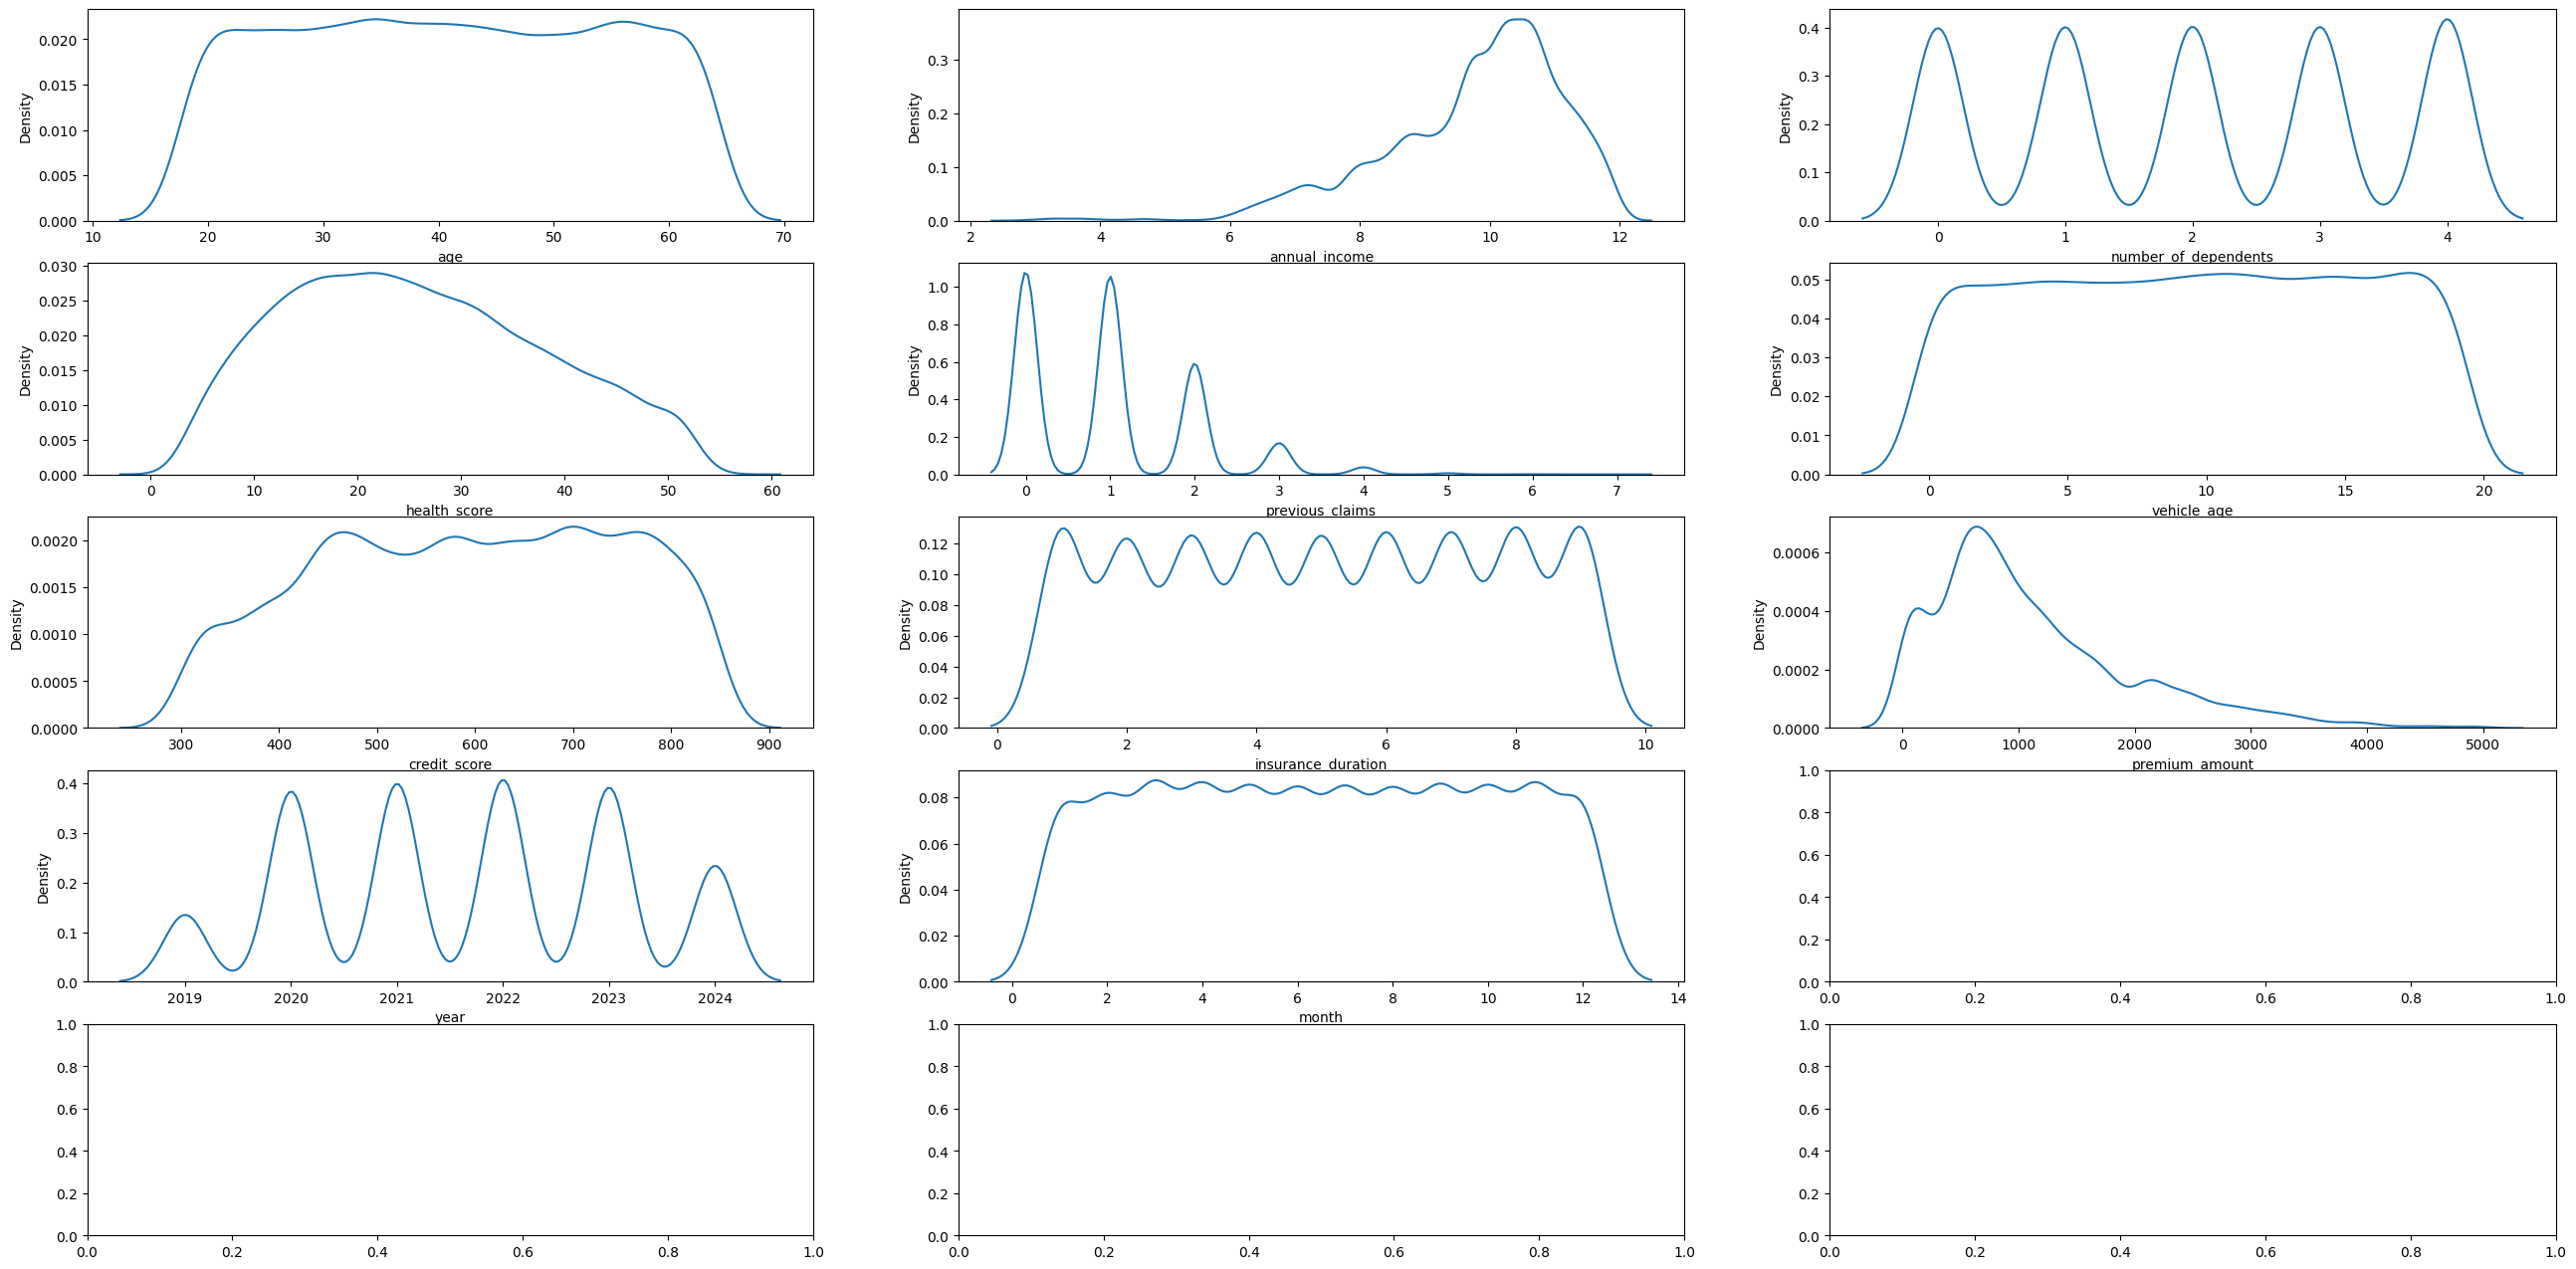

In [190]:
df_num = train_df.select_dtypes(include=np.number)
df_num_subsample = train_df.select_dtypes(include=np.number)

features = list(df_num.columns)
fig, axes = plt.subplots(5, len(features) // 5 + 1, figsize=(32, 16))

for axe, col in zip(axes.flatten(), features):
    sns.kdeplot(data=df_num, x=col, ax=axe)

In [191]:
y = train_df['premium_amount']

X = train_df.drop(columns=['premium_amount'])

# Разделение данных на обучающую и тестовую выборки с сохранением распределения
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

In [192]:
#Строим модель

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

#Столбцы Education Level и Policy Type кодируем Ordinal Encoder (есть порядок)
#Gender Marital Status, Location через one hot (небольшое количество уникальных)


# Трансформер для категориальных признаков с OneHotEncoder
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Трансформеры для категориальных признаков с OrdinalEncoder
education_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[["Bachelor's", 'High School', "Master's", 'PhD']]))
])

feedback_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])) 
])

exercise_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rarely', 'Monthly', 'Weekly', 'Daily']])) 
])

policy_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium']]))
])

location_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rural', 'Suburban', 'Urban']]))
])

In [193]:
numerical_features = X_train.select_dtypes(include=np.number).columns.to_list()
numerical_features.remove('premium_amount')
onehot_features = ['marital_status', 'gender', 'smoking_status', 'property_type']
education_features = ['education_level']
policy_feature = ['policy_type']
feedback_feature = ['customer_feedback']
exercise_feature = ['exercise_frequency']
location_feature = ['location']

In [194]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor

numeric_transforms = [
    ('imputer', SimpleImputer(strategy='median')),
]

num_transformer = Pipeline(steps=numeric_transforms)

feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('onehot', onehot_transformer, onehot_features),
        ('education', education_transformer, education_features),
        ('policy', policy_transformer, policy_feature),
        ('feedback', feedback_transformer, feedback_feature),
        ('exrcise', exercise_transformer, exercise_feature),
        ('location', location_transformer, location_feature)
    ])

model = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', RandomForestRegressor())
])


In [195]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month']),
                                                 ('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_freq...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rarely',
                                                                                               'Monthly',
                                                                                               'Weekly',
                                                                                               'Daily']]))]),
                                                  ['exercise_frequency']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('regression', RandomForestRegressor())])

In [196]:

predict = model.predict(X_test)

In [197]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

def print_score(model_name, funcs, y, y_pred):
    print(f'Score for {model_name}')
    for func in funcs:
        print(f'{func.__name__}: {func(y, y_pred):.4f}')
    print()


print_score('RF регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], y_test, predict)

Score for RF регрессия
mean_absolute_error: 669.4753
mean_squared_error: 759276.3558
mean_absolute_percentage_error: 3.1555
r2_score: 0.0114



In [198]:
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.creation import DecisionTreeFeatures

In [199]:
y = train_df['premium_amount']



X = train_df.drop(columns=['premium_amount', 'policy_start_date'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
X_train

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,customer_feedback,smoking_status,exercise_frequency,property_type,year,month
id,,,,,,,,,,,,,,,,,,,,
786463,23.0,Male,7.741534,Single,2.0,PhD,Self-Employed,31.487068,Suburban,Premium,2.0,3.0,456.0,3.0,Poor,No,Rarely,Apartment,2020,12
1157143,59.0,Female,11.124804,Married,4.0,High School,Employed,32.252423,Rural,Premium,1.0,11.0,434.0,7.0,Average,Yes,Monthly,Apartment,2024,7
1105753,20.0,Male,10.549019,Single,2.0,PhD,Self-Employed,34.057942,Suburban,Comprehensive,1.0,14.0,485.0,3.0,Good,No,Daily,Condo,2022,5
665372,42.0,Male,10.482430,Single,4.0,High School,Self-Employed,4.788293,Suburban,Basic,0.0,10.0,484.0,3.0,Average,No,Daily,Apartment,2020,11
1178855,47.0,Female,6.966967,Married,0.0,PhD,Self-Employed,20.454418,Rural,Premium,2.0,7.0,748.0,7.0,Poor,Yes,Daily,Condo,2023,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657450,54.0,Female,10.330421,Divorced,2.0,Master's,Unemployed,26.379850,Rural,Basic,1.0,16.0,485.0,5.0,Good,Yes,Monthly,House,2020,7
788324,45.0,Female,11.797066,Divorced,3.0,PhD,Self-Employed,19.094705,Suburban,Comprehensive,1.0,6.0,336.0,6.0,Good,No,Daily,Condo,2023,5
664153,47.0,Male,11.209981,Divorced,0.0,PhD,Employed,19.793522,Urban,Comprehensive,2.0,4.0,637.0,9.0,Average,Yes,Monthly,Condo,2022,10


In [201]:
import featuretools as ft

In [202]:
from feature_engine.imputation import CategoricalImputer


onehot_features = ['marital_status', 'gender', 'smoking_status', 'property_type']

encoder = OneHotEncoder(variables=onehot_features, drop_last=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)




In [203]:
from feature_engine.encoding import OrdinalEncoder

encoder = OrdinalEncoder(variables=['education_level', 'customer_feedback', 'exercise_frequency', 'policy_type', 'location', 'occupation'])
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [204]:
X_train.shape

(15360, 22)

In [205]:
from feature_engine.creation import MathFeatures

num_features = X_train.select_dtypes(include=np.number).columns.to_list()

MF = MathFeatures(
    variables=['education_level', 'annual_income'],
    func=['sum', 'prod', 'mean', 'std']
)

X_train = MF.fit_transform(X_train)
X_test = MF.transform(X_test)

In [206]:
from feature_engine.creation import DecisionTreeFeatures

dtf = DecisionTreeFeatures(features_to_combine=2) # комбинироваться по 2 столбца
dtf.fit(X_train, y_train)

DecisionTreeFeatures(features_to_combine=2)

In [207]:
from feature_engine.discretisation import DecisionTreeDiscretiser

discretiser = DecisionTreeDiscretiser(cv=3, scoring='neg_mean_squared_error', variables=num_features)

# Обучение и преобразование обучающей выборки
X_train_discretised = discretiser.fit_transform(X_train, y_train)

# Преобразование тестовой выборки
X_test_discretised = discretiser.transform(X_test)

print("\nОбучающая выборка после дискретизации:")
print(X_train_discretised.head())


Обучающая выборка после дискретизации:
                 age  annual_income  number_of_dependents  education_level  \
id                                                                           
786463   1110.909071    1239.760334           1159.778289      1103.869376   
1157143  1110.909071    1101.809374           1102.924604      1137.563586   
1105753  1110.909071    1101.809374           1159.778289      1103.869376   
665372   1110.909071    1101.809374           1102.924604      1137.563586   
1178855  1110.909071    1037.491284           1125.639500      1103.869376   

          occupation  health_score     location  policy_type  previous_claims  \
id                                                                              
786463   1119.365489   1110.740826  1093.635356  1118.156614      1169.598418   
1157143  1119.365489   1110.740826  1110.167578  1118.156614      1093.577085   
1105753  1119.365489   1110.740826  1093.635356  1106.374001      1093.577085   
665372  

In [208]:
model = RandomForestRegressor()
model.fit(X_train, y_train) 

RandomForestRegressor()

In [209]:
predict = model.predict(X_test)
print_score('RF регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], y_test, predict)


Score for RF регрессия
mean_absolute_error: 666.5441
mean_squared_error: 758002.9392
mean_absolute_percentage_error: 3.1399
r2_score: 0.0131



In [245]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

data = [importances, std]

df = pd.DataFrame({
    'importance': importances,
    'std': std
})

df.index = X_train.columns


In [248]:
df

,importance,std
age,0.077112,0.007108
annual_income,0.096908,0.013118
number_of_dependents,0.030374,0.003985
education_level,0.003246,0.001169
occupation,0.018466,0.003383
health_score,0.113448,0.009586
location,0.018899,0.003152
policy_type,0.018474,0.002932
previous_claims,0.025864,0.010170
vehicle_age,0.063901,0.006015


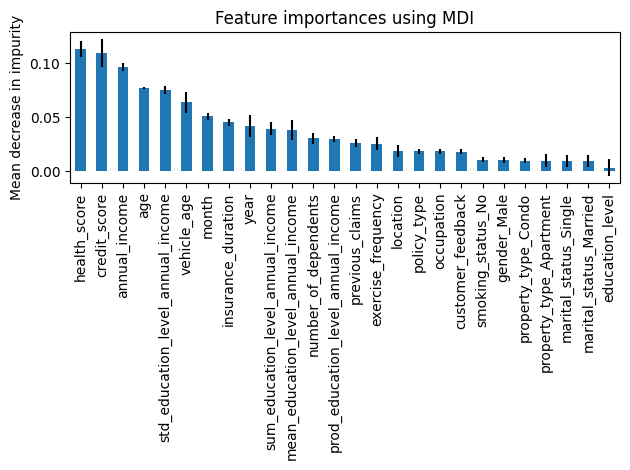

In [247]:

fig, ax = plt.subplots()
df['importance'].sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()